In [23]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc và hợp nhất các tệp CSV
files = glob.glob("D:\\code\\proj_ml\\ML_Project\\data\\saved\\*.csv")
data_list = []

for file in files:
    df = pd.read_csv(file, parse_dates=['Date'])
    data_list.append(df)

# Hợp nhất các DataFrame thành một DataFrame lớn
data = pd.concat(data_list, ignore_index=True)

# Đặt 'Date' làm chỉ mục
data.set_index('Date', inplace=True)

# Sắp xếp dữ liệu theo ngày để đảm bảo thứ tự đúng
data.sort_index(inplace=True)

# Dịch chuyển biến mục tiêu (giá vàng đóng cửa) 1 ngày để dự đoán giá đóng cửa ngày hôm sau
data['next_day_gold_close'] = data['gold_close'].shift(-1)

# Loại bỏ hàng cuối cùng vì không có giá trị mục tiêu
data.drop(data.tail(1).index, inplace=True)

In [24]:
data.dtypes

copper                 float64
crude_oil              float64
DXY                    float64
EURUSD                 float64
gold_open              float64
gold_high              float64
gold_low               float64
gold_close             float64
MSCI                   float64
NASDAQ                 float64
NLR                    float64
platinum               float64
RUT                    float64
silver                 float64
SP500                  float64
VIX                    float64
next_day_gold_close    float64
dtype: object

In [25]:
# Xử lý các giá trị NaN
data = data.dropna()

# Chọn các đặc trưng và biến mục tiêu
features = ['copper', 'crude_oil', 'DXY', 'EURUSD', 'MSCI', 'NASDAQ', 'NLR', 'platinum', 'RUT', 'silver', 'SP500', 'VIX']
target = 'next_day_gold_close'

X = data[features]
y = data[target]

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa các đặc trưng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sử dụng GridSearchCV để tìm tham số tốt nhất cho mô hình KNN
param_grid = {'n_neighbors': np.arange(1, 30)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

# Lấy tham số tốt nhất
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best number of neighbors: {best_n_neighbors}")

# Tạo và huấn luyện mô hình KNN với tham số tốt nhất
knn = KNeighborsRegressor(n_neighbors=best_n_neighbors)
knn.fit(X_train_scaled, y_train)

# Dự đoán
y_pred = knn.predict(X_test_scaled)


Best number of neighbors: 1


In [26]:
# Chuyển y_test thành mảng NumPy
y_test_array = y_test.values

# Tính toán các chỉ số đánh giá
mape = np.mean(np.abs((y_test_array - y_pred) / y_test_array))
rmse = np.sqrt(mean_squared_error(y_test_array, y_pred))
r2 = r2_score(y_test_array, y_pred)

# In kết quả
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

Mean Absolute Percentage Error (MAPE): 0.0189
Root Mean Squared Error (RMSE): 40.2728
R2 Score: 0.9840


In [27]:
# Dự đoán giá vàng ngày mai dựa trên dữ liệu hôm nay
latest_data = data.tail(1)[features]
latest_data_scaled = scaler.transform(latest_data)
tomorrow_gold_price = knn.predict(latest_data_scaled)
print(f"Predicted gold price for tomorrow: {tomorrow_gold_price[0]:.4f}")

Predicted gold price for tomorrow: 2385.5000


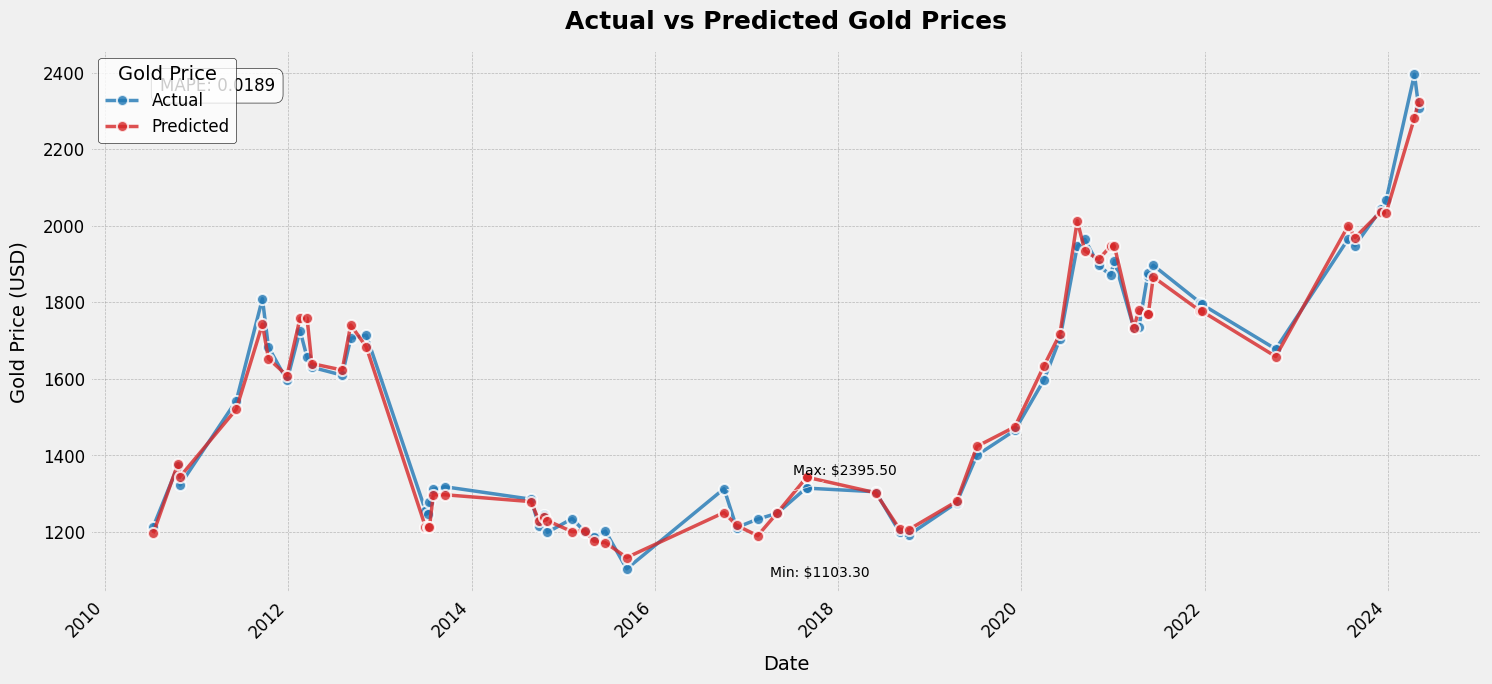

In [28]:
# Reset the index to use the date for plotting
X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

# Create a DataFrame for actual vs predicted values
comparison_df = pd.DataFrame({
    'Date': X_test['Date'],
    'Actual': y_test['next_day_gold_close'],
    'Predicted': y_pred
})

# Sort by date for better visualization
comparison_df.sort_values('Date', inplace=True)

# Set the style for better aesthetics
plt.style.use('fivethirtyeight')

# Create the figure
plt.figure(figsize=(16, 8))

# Plot actual gold prices
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual', color='#1f77b4', linewidth=2.5, alpha=0.8, marker='o', markersize=8, markeredgecolor='white', markeredgewidth=1.5)

# Plot predicted gold prices
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted', color='#d62728', linewidth=2.5, alpha=0.8, marker='o', markersize=8, markeredgecolor='white', markeredgewidth=1.5)

# Set title and labels with larger font sizes
plt.title('Actual vs Predicted Gold Prices', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Gold Price (USD)', fontsize=14, labelpad=10)

# Customize grid
plt.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Improve x-axis date labels
plt.gcf().autofmt_xdate()
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add annotations for min and max points
actual_min_idx = comparison_df['Actual'].idxmin()
actual_max_idx = comparison_df['Actual'].idxmax()
pred_min_idx = comparison_df['Predicted'].idxmin()
pred_max_idx = comparison_df['Predicted'].idxmax()

plt.annotate(f'Min: ${comparison_df["Actual"].min():.2f}', xy=(comparison_df.iloc[actual_min_idx]['Date'], comparison_df.iloc[actual_min_idx]['Actual']), 
            xytext=(-100, -30), textcoords='offset points', fontsize=10, arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
plt.annotate(f'Max: ${comparison_df["Actual"].max():.2f}', xy=(comparison_df.iloc[actual_max_idx]['Date'], comparison_df.iloc[actual_max_idx]['Actual']), 
            xytext=(50, 10), textcoords='offset points', fontsize=10, arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2'))

# Enhance legend
legend = plt.legend(loc='upper left', fontsize=12, title='Gold Price', title_fontsize=14, edgecolor='black', facecolor='white')
legend.get_frame().set_alpha(0.8)

# Add MAPE score on the plot
plt.text(0.05, 0.95, f'MAPE: {mape:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', alpha=0.8))

# Save the plot as a high-quality image
# plt.savefig('gold_price_prediction.png', dpi=300, bbox_inches='tight')
# print("The plot has been saved as 'gold_price_prediction.png'")

# Display the plot
plt.show()